![banner](https://raw.githubusercontent.com/priyammaz/HAL-DL-From-Scratch/main/src/visuals/banner.png)

# Image Segmentation with UNets

Up till now we have been exploring applications of Computer Vision models for Image classification, but there are other things we can do like Image Segmentation! The architecture we will build will be very similar to the one proposed in the original [UNet implementation](https://arxiv.org/pdf/1505.04597) for Biomedical Image Segmentation. UNets are actually not all that different from AutoEncoders for which you can see my big deep dive [here](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders), with one important aspect added, Skip Connections!


#### Types of Segmentation

Before we dig into the UNet though, lets go over some of the types of image segmentation!

- Semantic Segmentation: For each pixel in an image, predict what is it? Dog, Cat, Car, etc... If we have a picture with 3 dogs, all the pixels of the dogs will be classified as Dog. 
- Instance Segmentation: For each pixel in an image, dentify multiple instances of different objects. For example, if we have a picture with 3 dogs, identify each dog individually, so it would be classes Dog1, Dog2, Dog3.
- Panoptic Segmentation: This combines Instance and Semantic Segmentation, so we would identify for each pixel what image class it belongs to (i.e. what is it?) and also identify each individual occurance (i.e. which instance of it is it?) 

### Prerequisite
To get some intuition on residual connections (also known as skip connections), definitely take a look at my [ResNet](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Computer%20Vision/ResNet) tutorial so you can see why this small architectural change causes significant performance improvement for Deeper neural networks. But lets get started with UNets!

## High Level Overview

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/autoencoder_vs_unet.png?raw=true" width="1000"/>
</div>

UNets are not all that different from AutoEncoders, but they have the extra skip connections that symmetrically connect portions of the model. These skip connections, also known as residual connections, can come into forms, additive and concatenation. In our ResNet implementation, we made use of the additive residual connection, but UNet skip connections make use of concatenating that information. The concatenation of the UNet image features will happen on the channel dimension. 

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/additive_vs_concat_residual.png?raw=true" width="1000"/>
</div>

## Things to Keep in Mind

Lets pretend we are working with a typical image tensor of shape **[Batch x Channels x Height x Width]**, or for short **[B,C,H,W]**.
- When doing additive residual connections everything has to be the same. If the input tensor is **[B,C1,H1,W1]** and a second tensor is **[B,C2,H2,W2]**, we can only add them together if the tensors are of the same shape. Therefore **C1** has to be equal to **C2**, **H1** is equal to **H2** and **W1** is equal to **W2**. The output of this tensor will be the same size as the inputs!
- When doing concatenating residual connections, the height and width of the tensors have to be the same, but the number of channels doesn't necessarily need to be. If the input tensor is **[B,C1,H1,W1]** and a second tensor is **[B,C2,H2,W2]**, then **H1** is equal to **H2** and **W1** is equal to **W2**, and the number of channels in the output will be **C1+C2**. Therefore the final output will be **[B, C1+C2, H, W]**.


### Lets Build our Dataset First

Before we dig into the details of the UNet, lets first build our dataset! We will be training on Carvana Dataset [download it here](https://www.kaggle.com/c/carvana-image-masking-challenge).

We will include a few things in our dataset class:
- Normalization of images: We will apply typical Imagenet normalization constants
- Random Crops and Resizes of the Images: Grab random crops of different sizes (between some ratios) form the image and then resize to the models expected input size
- Random Horizontal Flipping: Should also help with overfitting and generalization.

**Note**: Any transformation we apply to our image must also be applied to the annotations, we will have to write a little bit of logic to handle that!


In [139]:
import os
import random
from PIL import Image
import pickle
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.cuda.amp import GradScaler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import color
from transformers import get_cosine_schedule_with_warmup

path_to_data = "../../data/carvana"

In [15]:
class CarvanaDataset(Dataset):
    """
    Carvana Class: This will do exactly what the ADE20K class was doing, but also include a random sampling
    of data as Carvana doesn't automatically split the dataset into training and validation (with an included seed)
    """
    def __init__(self, path_to_data, train=True, image_size=128, random_crop_ratio=(0.5, 1), seed=0, test_pct=0.1):
        self.path_to_data = path_to_data
        self.train = train
        self.image_size = image_size
        self.min_ratio, self.max_ratio = random_crop_ratio

        ### Get Path to Images and Segmentations ###
        self.path_to_images = os.path.join(self.path_to_data, "train")
        self.path_to_annotations = os.path.join(self.path_to_data, "train_masks")

        ### Get All Unique File Roots ###
        file_roots = [path.split(".")[0] for path in os.listdir(self.path_to_images)]

        ### Random Split Dataset into Train/Test ###
        random.seed(0)
        testing_data = random.sample(file_roots, int(test_pct*len(file_roots)))
        training_data = [sample for sample in file_roots if sample not in testing_data]

        if self.train:
            self.file_roots = training_data
        else:
            self.file_roots = testing_data
            
        ### Store all Transforms we want ###
        self.resize = transforms.Resize(size=(self.image_size, self.image_size))
        self.normalize = transforms.Normalize(mean=(0.48897059, 0.46548275, 0.4294), 
                                              std=(0.22861765, 0.22948039, 0.24054667))
        self.random_resize = transforms.RandomResizedCrop(size=(self.image_size, self.image_size))
        self.horizontal_flip = transforms.RandomHorizontalFlip(p=1)
        self.totensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_roots)

    def __getitem__(self, idx):

        ### Grab File Root ###
        file_root = self.file_roots[idx]

        ### Get Paths to Image and Annotation ###
        image = os.path.join(self.path_to_images, f"{file_root}.jpg")
        annot = os.path.join(self.path_to_annotations, f"{file_root}_mask.gif")

        ### Load Image and Annotation ###
        image = Image.open(image).convert("RGB")
        annot = Image.open(annot)

        ### Train Image Transforms ###
        if self.train:

            ### Resize Image and Annotation ###
            if random.random() < 0.5:
                
                image = self.resize(image)
                annot = self.resize(annot)

            ### Random Resized Crop ###
            else:

                ### Get Smaller Side ###
                min_side = min(image.size)
    
                ### Get a Random Crop Size with Ratio ###
                random_ratio = random.uniform(self.min_ratio, self.max_ratio)

                ### Compute Crop Size ###
                crop_size = int(random_ratio * min_side)

                ### Get Parameters of Random Crop ###
                i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))

                ### Crop Image and Annotation ###
                image = TF.crop(image, i, j, h, w)
                annot = TF.crop(annot, i, j, h, w)

                ### Resize Image to Desired Image Size ###
                image = self.resize(image)
                annot = self.resize(annot)
            

            ### Random Horizontal Flip ###
            if random.random() < 0.5:
                image = self.horizontal_flip(image)
                annot = self.horizontal_flip(annot)

        ### Validation Image Transforms ###
        else:

            image = self.resize(image)
            annot = self.resize(annot)
                
        ### Convert Everything to Tensors ###
        image = self.totensor(image)
        annot = torch.tensor(np.array(annot), dtype=torch.float) # BCEWithLogits needs float tensor

        ### Normalize Image ###
        image = self.normalize(image)

        return image, annot

### A Visual of the original UNet Implementation

Lets quickly take a look at the original figure from the UNet paper!

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/original_unet.png?raw=true" width="600"/>
</div>

Just like an autoencoder, the encoder piece of the model takes an input image and comresses down to a bottleneck. The decoder then takes all the information compressed into the bottleneck and decompresses it back to the original image shape. We can then used these decompressed features and use them to predict our segmentation masks. Now instead of looking at the original figure, I drew a slightly more detailed version that will give some more information about what is going on in the model!

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/my_unet.png?raw=true" width="1000"/>
</div>

**Note**

The UNet we will be implementing is a little different from the original, and is actually close to UNets used for [Denoising Diffusion Models](https://arxiv.org/pdf/2006.11239). There is no significant difference between normal UNets and those used for Diffusion, I am just doing this to give a more up-to-date structure that we will reuse in future projects!

There are three components to this model:
- **Residual Blocks:** These will be a stack of convolutions connected with **additive residual connections** and other things for good measure like GroupNorms (You can see why GroupNorm is preferred over BatchNorm [here](https://arxiv.org/pdf/1803.08494)). The important part is Residual Blocks do not change image size, but can change the number of image channels. 
- **Downsampling Convolutions:** This will be the convolution that will downsample our image size by a factor of 2. This means if we start with a tesor of size **[B, C, H, W]**, the downsampling convolution will make it **[B, C, H/2, W/2]**, and repeating it multiple times (lets say 3 times) will make the image **[B, C, H/8, W/8]**. We will be able to perform downsampling by doing strided convolutions, with a stride of 2.
- **Upsampling Blocks:** To actually do our skip connections, the size of the tensors have to match, therefore we need to upsample our bottleneck as many times as we had downsampled the input. There are two ways we can do this upsampling:
    - Transposed Convolutions (Used in the Original UNet) which is a learned upsampling and should be perfectly fine for semantic segmentation
    - Upsample + Conv is a technique used more today for image generation, where we use some non-learnable upsampling technique like bilinear interpolation, and then apply a convolution right after. You can see why we would use this [here](https://distill.pub/2016/deconv-checkerboard/)!
 
How we do this is a bit arbritary so this is the pattern I will do:

- Encoder: Residual Block (with no change in the number of channels), Downsampling Convolution (Downsample image by a factor of 2), Residual Block (Double number of channels)
- Decoder: Concatenate stored tensor from Encoder, Residual Block that will change the number of channels to be the number of channels of the next residual tensor (this is arbriratry you can pick something else) and then an Upsampling Block so we match the height and width of the next residual tensor for future concatenating.

### Part 1: Residual Block

Again, the key part of the residual block is we want to be able to control the input and output number of channels, but the spatial dimensions must remain the same!

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groupnorm_num_groups):
        super().__init__()

        ### Input Convolutions + GroupNorm ###
        self.groupnorm_1 = nn.GroupNorm(groupnorm_num_groups, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")

        ### Input + Time Embedding Convolutions + GroupNorm ###
        self.groupnorm_2 = nn.GroupNorm(groupnorm_num_groups, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")

        ### Residual Layer ###
        self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):

        ### Store Copy for Residual ###
        residual_connection = x
        
        ### Input GroupNorm and Convolutions ###
        x = self.groupnorm_1(x)
        x = F.relu(x)
        x = self.conv_1(x)

        ### Group Norm and Conv Again! ###
        x = self.groupnorm_2(x)
        x = F.relu(x)
        x = self.conv_2(x)

        ### Add Residual and Return ###
        x = x + self.residual_connection(residual_connection)
        
        return x



### Part 2: Upsampling Block

In the decoder portion of our UNet, we have to upsample our images. During downsampling, we typically downsample by a factor of 2, so when upsampling, we also have to upsample by 2! We again have two options for upsampling: (1) Interpolation + Convolution or (2) Transpose Convolution. 

#### Convolutions Review

Lets again remind ourselves what a regular convolution is doing (with these incredible GIFs from the repo [conv_arithmetic](https://github.com/vdumoulin/conv_arithmetic?tab=readme-ov-file))

<div>
<img src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif?raw=true" width="250"/>
</div>

The entire purpose of a convolution is to take the convolution filters and slide them across your image, and at every location you will do the dot product between your filter coefficients and image pixel values. This effectively downsamples (or summarizes) your image, because if you have a filter of size **3 x 3**, then the 9 numbers in the filter multiply by the 9 numbers in the image and becomes a single value. Therefore, this is a learned compression of important features inside the image.

#### Transpose Convolutions (Deconvolutions)

Transposed convolutions are new, and they do exactly the opposite of convolutions.

<div>
<img src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides_transposed.gif?raw=true" width="250"/>
</div>

Instead of downsampling an image, Transpose Convolutions upsample. They also learn filter coefficients, such that when they are convolved with an image, it will increase the spatial resolution. As you can see above, the **2 x 2** image (when padded appropriately before the transpose convolution operation) will be upsampled to a **4 x 4**

Transpose convolutions, atleast the way PyTorch has them implemented, have very similar function arguments as compared to regular convolutions, except for padding, where there are actually two types of padding. The following is taken from the PyTorch documentation for [TransposeConvolutions](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

- **padding**: The padding argument effectively adds dilation * (kernel_size - 1) - padding amount of zero padding to both sizes of the input. This is set so that when a Conv2d and a ConvTranspose2d are initialized with same parameters, they are inverses of each other in regard to the input and output shapes.
- **output_padding**: However, when stride > 1, Conv2d maps multiple input shapes to the same output shape (Remember, the formula for the output of a convolution has a floor function, so multiple input sizes will result in the same output size). output_padding is provided to resolve this ambiguity by effectively increasing the calculated output shape on one side. Note that output_padding is only used to find output shape, but does not actually add zero-padding to output.

#### Lets Quickly Take a Look at This

Lets create a convolution that downsamples by 2 (by striding by 2 and padding by 1) and then a transpose convolution with the exact same arguments and see what we get. 

In [17]:
### Convolutional Downsample by 2 ###
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)

### Transpose Convolutional Upsample by 2 ###
tconv = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)

### Random Tensor with spatial size 64 x 64 ###
rand_tensor = torch.randn(2,3,64,64)

### Pass Tensor through Convolutions ###
conv_out = conv(rand_tensor)
print("Convolution Output Shape:", conv_out.shape)
tconv_out = tconv(conv_out)
print("Transpose Convolution Output Shape:", tconv_out.shape)

Convolution Output Shape: torch.Size([2, 3, 32, 32])
Transpose Convolution Output Shape: torch.Size([2, 3, 63, 63])


Do you notice something gone wrong? The output of the transpose convolution returned a **63 x 63** tensor, not **64 x 64**, and this is because multiple shape inputs to a convolution can lead to the exact same output shape so its arbritrary. Here is an example of how multiple shapes lead to the same output shape. Lets pass in a **64 x 64** and a **63 x 63** tensor into our convolution to see the outputs

In [18]:
rand_tensor_1 = torch.randn(2,3,64,64)
print(conv(rand_tensor_1).shape)

rand_tensor_2 = torch.randn(2,3,63,63)
print(conv(rand_tensor_2).shape)

torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 32, 32])


So it definitely shows, that both a **64 x 64** and a **63 x 63** will lead to the exact same output shape. This means when doing Transpose Convolutions, PyTorch doesn't actually know which output shape you want, and by default it gives the smaller one. To deal with this we can provide the argument to the transpose convolution **output_padding** as 1. This will tell it to pad one side of the image so our **63 x 63** becomes a **64 x 64**. Lets try that quickly:


In [19]:
### Convolutional Downsample by 2 ###
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)

### Transpose Convolutional Upsample by 2 ###
tconv = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

### Random Tensor with spatial size 64 x 64 ###
rand_tensor = torch.randn(2,3,64,64)

### Pass Tensor through Convolutions ###
conv_out = conv(rand_tensor)
print("Convolution Output Shape:", conv_out.shape)
tconv_out = tconv(conv_out)
print("Transpose Convolution Output Shape:", tconv_out.shape)


Convolution Output Shape: torch.Size([2, 3, 32, 32])
Transpose Convolution Output Shape: torch.Size([2, 3, 64, 64])


Now you can see, the input shape matches the output shape! I think this is one of the toughest parts of convolutions, often when building these models with residual connections, you can have two tensors that are barely off in shape. This is one way to deal with this, by messing with the transpose convolutions! There are a lot of transpose convolutions though that can upscale an image by a factor of 2, such as using a kernel size of 2 and stride of 2 (this only works I think when the image size is a factor of 2).

In [20]:
### Convolutional Downsample by 2 ###
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)

### Transpose Convolutional Upsample by 2 ###
tconv = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=2, stride=2)

### Random Tensor with spatial size 64 x 64 ###
rand_tensor = torch.randn(2,3,63,63)

### Pass Tensor through Convolutions ###
conv_out = conv(rand_tensor)
print("Convolution Output Shape:", conv_out.shape)
tconv_out = tconv(conv_out)
print("Transpose Convolution Output Shape:", tconv_out.shape)


Convolution Output Shape: torch.Size([2, 3, 32, 32])
Transpose Convolution Output Shape: torch.Size([2, 3, 64, 64])


So you can see that if you are ok with the convolutions and transpose convolutions not being exact mirror images of each other, then this works as well! I'd say its personal preference, but I think its more just getting it to work, although I haven't tested rigorously myself, I would assume this wont cause significant changes in performance. 

### Upsampling Block

With all this in mind, lets write our Upsampling block! Again, the important part is we can control the number of input and output channels and we ensure the output is exactly twice the spatial resolution of the input. 

In [21]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, interpolate=False):
        super().__init__()

        if interpolate:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
            )

        else:
            self.upsample = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        upsampled = self.upsample(inputs)
        assert (upsampled.shape == (batch, channels, height*2, width*2))
        return upsampled
        


## Write the UNET

This is a slightly more verbose way of defining a UNET, but I did it this way just so things make a bit more sense. Instead of directly writing the convolutional layers, we will create a config first to structure what type of UNET we want, and then we can build the convolutions and forward functions after. The function arguments here are:

- **in_channels**: How many input channels in the image
- **num_classes**: How many classes are we predicting in our labels
- **start_dim**: How many channels do we initially expand our image to before doing all the UNET stuff
- **dim_mults**: Channel expansion factor at every block of the UNET (multiply values give by the initial start_dim)
- **residual_blocks_per_group**: How many residual blocks do we want at every block of the UNET
- **groupnorm_num_groups**: We will use GroupNorm in place of BatchNorm, so how many groups do we want
- **interpolated_upsample**: Do we want to use (1) Interpolation + Convolution or (2) Transpose Convolution
- **skip_connection**: Do we want skip connections between the encoder and decoder?



In [22]:
class UNET(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 num_classes=150, 
                 start_dim=64, 
                 dim_mults=(1,2,4,8), 
                 residual_blocks_per_group=1, 
                 groupnorm_num_groups=16, 
                 interpolated_upsample=False):
        
        super().__init__()
  
        self.input_image_channels = in_channels
        self.interpolate = interpolated_upsample

        #######################################
        ### COMPUTE ALL OF THE CONVOLUTIONS ###
        #######################################

        ### Get Number of Channels at Each Block ###
        channel_sizes = [start_dim*i for i in dim_mults]
        starting_channel_size, ending_channel_size = channel_sizes[0], channel_sizes[-1]

        ### Compute the Input/Output Channel Sizes for Every Convolution of Encoder ###
        self.encoder_config = []
        
        for idx, d in enumerate(channel_sizes):
            ### For Every Channel Size add "residual_blocks_per_group" number of Residual Blocks that DONT Change the number of channels ###
            for _ in range(residual_blocks_per_group):
                self.encoder_config.append(((d, d), "residual")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels x Height x Width)

            ### After Residual Blocks include Downsampling (by factor of 2) but dont change number of channels ###
            self.encoder_config.append(((d,d), "downsample")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels x Height/2 x Width/2)
            
            ### If we are not at the last channel size include a channel upsample (typically by factor of 2) ###
            if idx < len(channel_sizes) - 1:
                self.encoder_config.append(((d,channel_sizes[idx+1]), "residual")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels*2 x Height x Width)
            
        ### The Bottleneck will have "residual_blocks_per_group" number of ResidualBlocks each with the input/output of our final channel size###
        self.bottleneck_config = []
        for _ in range(residual_blocks_per_group):
            self.bottleneck_config.append(((ending_channel_size, ending_channel_size), "residual"))

        ### Store a variable of the final Output Shape of our Encoder + Bottleneck so we can compute Decoder Shapes ###
        out_dim = ending_channel_size

        ### Reverse our Encoder config to compute the Decoder ###
        reversed_encoder_config = self.encoder_config[::-1]

        ### The output of our reversed encoder will be the number of channels added for residual connections ###
        self.decoder_config = []
        for idx, (metadata, type) in enumerate(reversed_encoder_config):
            ### Flip in_channels, out_channels with the previous out_dim added on ###
            enc_in_channels, enc_out_channels = metadata

            ### Compute Number of Input Channels (if we want concatenated skip connection or not) ###
            concat_num_channels = out_dim + enc_out_channels
            self.decoder_config.append(((concat_num_channels, enc_in_channels), "residual"))
                    
            if type == "downsample":
                ### If we did a downsample in our encoder, we need to upsample in our decoder ###
                self.decoder_config.append(((enc_in_channels, enc_in_channels), "upsample"))

            ### The new out_dim will be the number of output channels from our block (or the cooresponding encoder input channels) ###
            out_dim = enc_in_channels

        ### Add Extra Residual Block for residual from input convolution ###
        # hint: We know that the initial convolution will have starting_channel_size
        # and the output of our decoder will also have starting_channel_size, so the
        # final ResidualBlock we need will need to go from starting_channel_size*2 to starting_channel_size

        concat_num_channels = starting_channel_size*2
        self.decoder_config.append(((concat_num_channels, starting_channel_size), "residual"))
        
        
        #######################################
        ### ACTUALLY BUILD THE CONVOLUTIONS ###
        #######################################

        ### Intial Convolution Block ###
        self.conv_in_proj = nn.Conv2d(self.input_image_channels, 
                                      starting_channel_size, 
                                      kernel_size=3, 
                                      padding="same")
        
        self.encoder = nn.ModuleList()
        for metadata, type in self.encoder_config:
            if type == "residual":
                in_channels, out_channels = metadata
                self.encoder.append(ResidualBlock(in_channels=in_channels,
                                                  out_channels=out_channels,
                                                  groupnorm_num_groups=groupnorm_num_groups))
            elif type == "downsample":
                in_channels, out_channels = metadata
                self.encoder.append(
                    nn.Conv2d(in_channels, 
                              out_channels, 
                              kernel_size=3, 
                              stride=2, 
                              padding=1)
                    )

        
        ### Build Encoder Blocks ###
        self.bottleneck = nn.ModuleList()
        
        for (in_channels, out_channels), _ in self.bottleneck_config:
            self.bottleneck.append(ResidualBlock(in_channels=in_channels,
                                                 out_channels=out_channels,
                                                 groupnorm_num_groups=groupnorm_num_groups))

        ### Build Decoder Blocks ###
        self.decoder = nn.ModuleList()
        for metadata, type in self.decoder_config:
            if type == "residual":
                in_channels, out_channels = metadata
                self.decoder.append(ResidualBlock(in_channels=in_channels,
                                                  out_channels=out_channels,
                                                  groupnorm_num_groups=groupnorm_num_groups))
            elif type == "upsample":
                in_channels, out_channels = metadata
                self.decoder.append(UpsampleBlock(in_channels=in_channels, 
                                                  out_channels=out_channels,
                                                  interpolate=self.interpolate))

        ### Output Convolution ###
        self.conv_out_proj = nn.Conv2d(in_channels=starting_channel_size, 
                                       out_channels=num_classes,
                                       kernel_size=3, 
                                       padding="same")


    def forward(self, x):
        residuals = []

        ### Pass Through Projection and Store Residual ###
        x = self.conv_in_proj(x)
        residuals.append(x)

        ### Pass through encoder and store residuals ##
        for module in self.encoder:
            x = module(x)
            residuals.append(x)
           

        ### Pass Through BottleNeck ###
        for module in self.bottleneck:
            x = module(x)

        ### Pass through Decoder while Concatenating Residuals ###
        for module in self.decoder:

            if isinstance(module, ResidualBlock):
                
                ### Pass through Convs with Skip Connections ###
                residual_tensor = residuals.pop()
                x  = torch.cat([x, residual_tensor], axis=1)
                x = module(x)
                
            else:
                ### Pass Through Upsample Block ###
                x = module(x)


        ### Map back to num_channels for final output ###
        x = self.conv_out_proj(x)

        return x

model = UNET(skip_connection=True)
rand = torch.randn(4,3,256,256)
model(rand).shape

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

44983446

### Train Model 

In [78]:
def train(skip_connection=True,
          learning_rate=0.0008,
          batch_size=32,
          gradient_accumulation_steps=4,
          epochs=150,
          image_size=256,
          experiment_name="UNET_w_skips",
          device="cuda"):

    ### Load AMP Scaler ###
    scaler = GradScaler()
    
    ### Dataset Dependent Settings ###
    NUM_CLASSES = 1
    loss_func = nn.BCEWithLogitsLoss()
    
    ### Create Working Directory ###
    path_to_experiment = os.path.join("work_dir", experiment_name)
    if not os.path.exists(path_to_experiment):
        os.mkdir(path_to_experiment)
    
    path_to_model_save = os.path.join(path_to_experiment, experiment_name+".bin")
    path_to_logging_save = os.path.join(path_to_experiment, experiment_name+"_log.pkl")

    ### Set Training Device ###
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### Define Model ###
    model = UNET(skip_connection=skip_connection,
                 num_classes=NUM_CLASSES)
    
    model = model.to(device)
    
    ### Build DataLoaders ###
    micro_batchsize = batch_size // gradient_accumulation_steps
    train_data = CarvanaDataset(path_to_data, train=True, image_size=image_size)
    test_data = CarvanaDataset(path_to_data, train=False, image_size=image_size)
    train_dataloader = DataLoader(train_data, batch_size=micro_batchsize, shuffle=True, num_workers=8, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=micro_batchsize, shuffle=False, num_workers=8, pin_memory=True)

    ### Define Optimizer ###
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    ### Define Scheduler ###
    total_training_steps = int(epochs*len(train_dataloader) / gradient_accumulation_steps)
    print(f"Training for {total_training_steps} Steps")
    scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=int(0.1*total_training_steps), 
                                                num_training_steps=total_training_steps)

    ### Train Log ###
    training_log = {"train_losses": [], 
                    "train_accuracies": [], 
                    "test_losses": [],
                    "test_accuracies": []}

    best_test_loss = np.inf

    for epoch in range(1, epochs + 1):
        print("EPOCH: [{}/{}]".format(epoch, epochs))
        train_loss = []
        train_acc = []
        test_loss = []
        test_acc = []
        
        ### Model Training ###
        model.train()
        loop_train = tqdm(train_dataloader, total=len(train_dataloader), leave=True)

        gradient_accum_iter = 0
        for idx, (img, trgt) in enumerate(loop_train):
    
            with torch.autocast(device_type="cuda", dtype=torch.float16):

                ### Move Tensors to Device ###
                img, trgt = img.to(device), trgt.to(device)

                ### Pass Images through Model ###
                forward_out = model(img)

                ### Carvana has only a single output channel, with shape [B, 1, H, W], but our label is [B, H, W] so we have to squeeze our channel dimension ###
                forward_out = forward_out.squeeze(1)                    

                ### Compute CrossEntropy Loss ###
                train_loss_val = loss_func(forward_out, trgt)

                ### Scale Loss by Gradient Accumulation Steps ###
                train_loss_val = train_loss_val / gradient_accumulation_steps

            ### Store Loss ###
            train_loss.append(train_loss_val.item()*gradient_accumulation_steps)

            ### Compute the Gradients ###
            scaler.scale(train_loss_val).backward()

            # Threshold forward_out for predictions #
            predicted = torch.sigmoid(forward_out)
            predicted = (predicted > 0.5).int()

            ### Compute Accuracy ###
            accuracy = (predicted == trgt).sum() / torch.numel(predicted)
            train_acc.append(accuracy.item())

            ### Iterate the Accumulation Counter ###
            gradient_accum_iter += 1
            
            if gradient_accum_iter % gradient_accumulation_steps == 0:

                ### Unscale Gradients for Clipping ###
                scaler.unscale_(optimizer)

                ### Clip Gradients ###
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                ### Update Model and Scheduler ###
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
    
        ### MODEL EVALUATION ###
        model.eval()
        loop_test = tqdm(test_dataloader, total=len(test_dataloader), leave=True)
        with torch.no_grad():
            for idx, (img, trgt) in enumerate(loop_test):
                img, trgt = img.to(device), trgt.to(device)
                forward_out = model(img)

                forward_out = forward_out.squeeze(1)
                predicted = torch.sigmoid(forward_out)
                predicted = (predicted > 0.5).int()

                test_loss_val = loss_func(forward_out, trgt)
                test_loss.append(test_loss_val.item())

                ### Compute Accuracy ###
                accuracy = (predicted == trgt).sum() / torch.numel(predicted)
                test_acc.append(accuracy.item())

        ### Compute Average Performance for Epoch ###
        avg_train_loss, avg_test_loss = np.mean(train_loss), np.mean(test_loss)
        avg_train_acc, avg_test_acc = np.mean(train_acc), np.mean(test_acc)
    
        if avg_test_loss < best_test_loss:
            print("**SAVING**")
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), path_to_model_save)
            
        print("Training Loss:", avg_train_loss)
        print("Training Acc:", avg_train_acc)
        print("Validation Loss:", avg_test_loss)
        print("Validation Acc:", avg_test_acc)

        training_log["train_losses"].append(avg_train_loss)
        training_log["train_accuracies"].append(avg_train_acc)
        training_log["test_losses"].append(avg_test_loss)
        training_log["test_accuracies"].append(avg_test_acc)
    
        ### Save Training Log ###
        with open(path_to_logging_save, 'wb') as handle:
            pickle.dump(training_log, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return model, training_log

model, training_log = train(epochs=1, experiment_name="UNET_carvana")

# model, training_log = train(epochs=1, dataset="carvana", experiment_name="UNET_wo_skips_carvana", skip_connection=False)

Training for 143 Steps
EPOCH: [1/1]


  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.16246491779181554
Training Acc: 0.9361783904763
Validation Loss: 0.04896360432030633
Validation Acc: 0.98130002617836


In [134]:
def inference_image(model, path_to_image, path_to_annotation, image_size=256, visualize=True, device="cpu"):

    ### Set Model on Correct Device ###
    model = model.to(device)
    
    ### Set Preprocessing Steps ###
    resize = transforms.Resize(size=(image_size, image_size))
    normalize = transforms.Normalize(mean=(0.48897059, 0.46548275, 0.4294), 
                                     std=(0.22861765, 0.22948039, 0.24054667))
    totensor = transforms.ToTensor()
    topil = transforms.ToPILImage()

    ### Load Images ###
    image = Image.open(path_to_image).convert("RGB")
    annot = Image.open(path_to_annotation)
    width, height = annot.size 
    annot = np.array(annot) # This goes from 0 to 150 by default 

    ### Prepare Image for Inference ###
    proc_image = normalize(totensor(resize(image))).unsqueeze(0)

    ### Inference Model ###
    with torch.no_grad():
        pred = model(proc_image.to(device)).cpu()
        
    ### Process Inference ###
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).int()
    pred = F.interpolate(pred.type(torch.FloatTensor), size=(height, width))
    pred = np.array(pred.squeeze(), dtype=np.uint8)

    ### Overlay Masks on Images ###
    annot_color = color.label2rgb(annot,np.array(image))
    pred_color = color.label2rgb(pred,np.array(image))

    ### Plot Results! ###
    if visualize:
        
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(annot_color)
        ax[0].set_title("Ground Truth Segmentation")
        ax[0].axis("off")
        ax[1].imshow(pred_color)
        ax[1].set_title("Predicted Segmentation")
        ax[1].axis("off")
    
        plt.tight_layout()
        plt.show()

    return annot, pred


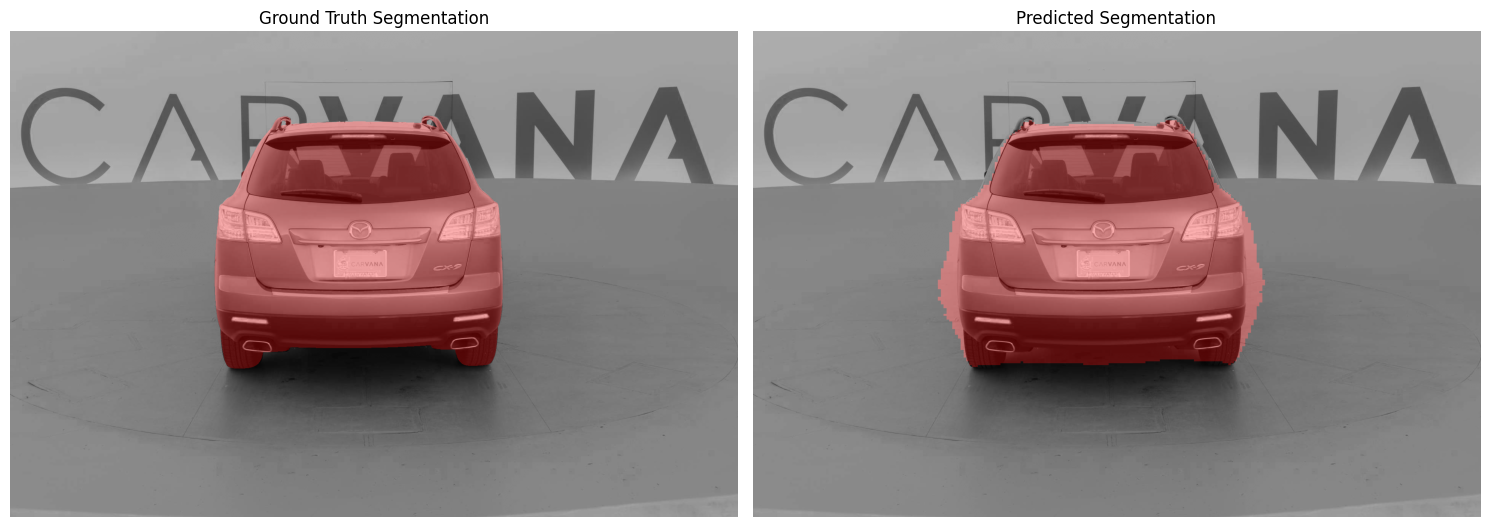

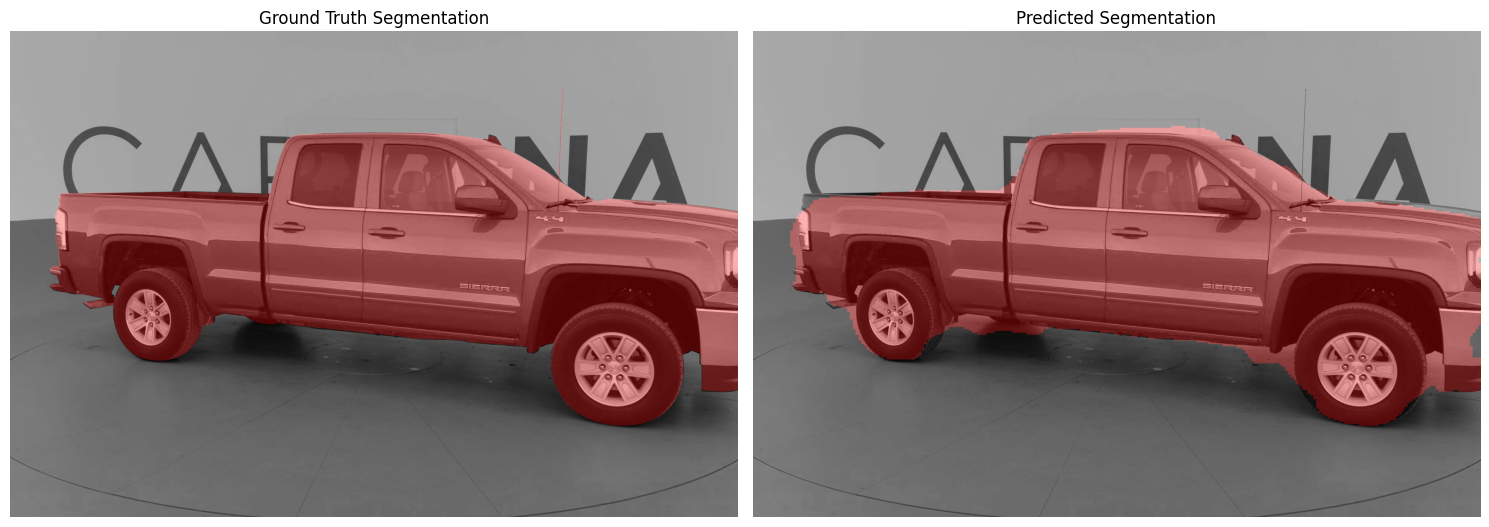

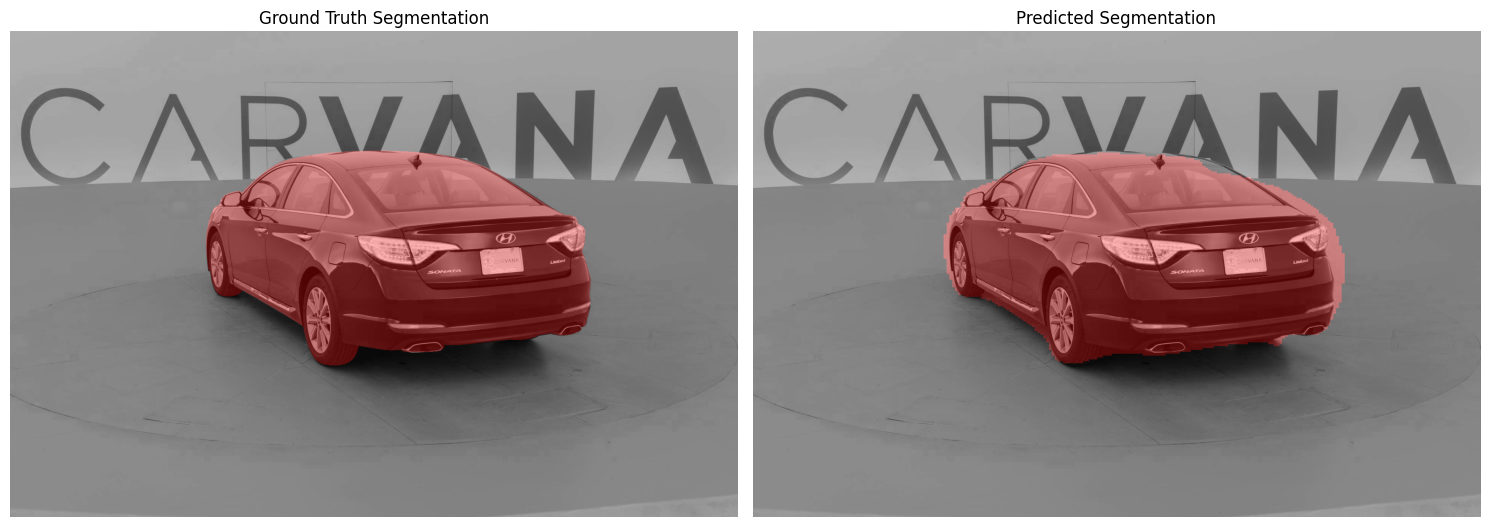

In [135]:
model = UNET(skip_connection=True, num_classes=1)
model.load_state_dict(torch.load("work_dir/UNET_w_skips_carvana/UNET_w_skips_carvana.bin"))

test_data = CarvanaDataset(path_to_data, train=False)
test_roots = test_data.file_roots

import random
for idx in random.sample(range(100), 3):
    path_to_image = os.path.join(test_data.path_to_images, test_roots[idx]+".jpg")
    path_to_annotation = os.path.join(test_data.path_to_annotations, test_roots[idx]+"_mask.gif")
    inference_image(model, path_to_image, path_to_annotation)

### Evaluating Model: Intersection over Union (IOU)

Pixelwise accuracy is not the best way to evaluate segmentation models all the time, instead we will use something called the Intersection over Union Metric, or IOU (also known as the **Jaccard Index**). This metric does exactly what you think, compute where the predicted mask overlaps with the ground truth mask, and then compute the union, or all pixels labeled our class value. Then we can just divide them, and get a ratio, where the closer we are to 1, the more perfect the segmentation is. 

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/intersection_over_union.png?raw=true" width="800"/>
</div>

In the example above, the intersection is the overlapping area between the two boxes, and the union is the total area of both boxes combined. The example on the right has much worse IOU, as the area of the overlapping box is much smaller then the union of the areas of both boxes. We can take a look at one of our own segmentation masks too. 

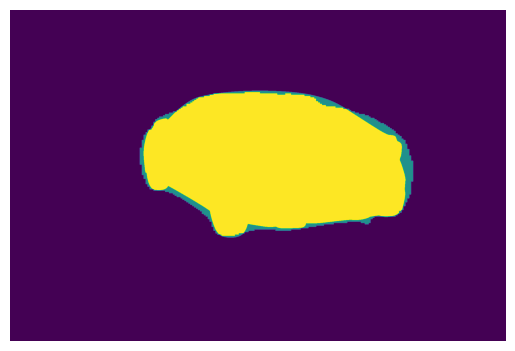

In [136]:
annot, pred = inference_image(model, path_to_image, path_to_annotation, visualize=False)
combined = annot + pred

plt.imshow(combined)
plt.axis("off")
plt.show()

We can see here that the intersection is the overlapping yellow region, and the union will be the combination of the yellow and green regions! So how can we compute Intersection over Union? We can just do boolean checks for overlapping predictions and divide by all annotated (correct and incorrect) values.

The logic is super simple, we have two binary masks (only 0,1 values), so lets add them together. The intersect will be where the values are 2 (1 + 1 will align) and the union is anywhere where it is not 0, (any value greater than 0, so 1 or 2). 

In [137]:
def compute_iou(annot, pred):
    combined = annot + pred
    iou = (combined==2).sum() / (combined > 0).sum()
    return iou

iou = compute_iou(annot, pred)
print("IOU for Image is:", iou)

IOU for Image is: 0.931711892620287


### Similarly we can compute the mIOU 

A common metric is the Mean IOU, so we can iterate through all our data and compute what that would be!

In [138]:
miou = []
for idx in tqdm(range(len(test_data))):
    path_to_image = os.path.join(test_data.path_to_images, test_roots[idx]+".jpg")
    path_to_annotation = os.path.join(test_data.path_to_annotations, test_roots[idx]+"_mask.gif")
    annot, pred = inference_image(model, path_to_image, path_to_annotation, visualize=False, device="cuda")
    iou = compute_iou(annot, pred)
    miou.append(iou)

print("The mIOU of our Model is:", np.mean(miou))

  0%|          | 0/508 [00:00<?, ?it/s]

The mIOU of our Model is: 0.9148872828223942
